This notebook provides examples of analysis of parcellated resting fMRI timeseries.

To grab the data, you should first do the following:

bash ~/fmri-analysis-vm/get_resting.sh

This will grab 6 sessions of parcellated resting timeseries, along with some information about the parcellation.

you will also need to install the python brain connectivity toolbox:

pip install git+git://github.com/aestrivex/bctpy



In [104]:
import os,glob
import nibabel
import numpy,pandas
import sklearn
import nilearn.input_data
from nilearn.plotting import plot_roi
from nilearn.image.image import mean_img
import bct
import scipy.stats
from collections import Counter

import matplotlib.pyplot as plt
import sys
sys.path.append('/home/vagrant/fmri-analysis-vm/analysis/utils')
from r2z import r_to_z,z_to_r

%matplotlib inline

In [60]:
roidatadir='/home/vagrant/data/ds031/sub-01/roidata'
roifiles=glob.glob(os.path.join(roidatadir,'sub*txt'))
roifiles.sort()

columns=['roinum','hemis','X','Y','Z',
          'lobe','region','powernet','yeo7net','yeo17net']
parceldata=pandas.DataFrame.from_csv(os.path.join(roidatadir,'parcel_data.txt'),
                                     sep='\t',header=None,index_col=None)

parceldata.columns=columns

data={}

for f in roifiles:
    subcode=os.path.basename(f).split('.')[0]
    data[subcode]=numpy.loadtxt(f)
    datasize=data[subcode].shape

cc=numpy.zeros((len(roifiles),datasize[1],datasize[1]))
subcodes=list(data.keys())
meancc=numpy.zeros((datasize[1],datasize[1]))
for i,k in enumerate(subcodes):
    cc[i,:,:]=numpy.corrcoef(data[k].T)
    meancc+=r_to_z(cc[i,:,:])
meancc=z_to_r(meancc/len(subcodes))


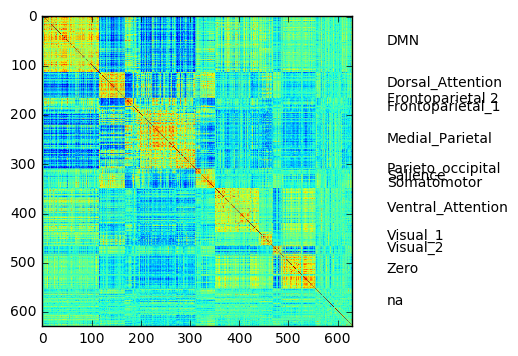

In [73]:
import scipy.cluster.hierarchy as sch
import pylab

idx=parceldata.powernet.argsort().values
powernet=parceldata.powernet.copy()
powernet.values.tolist()
powernet_sorted=[powernet[i] for i in idx]
breakpoints=[i for i in range(1,len(powernet_sorted)) if powernet_sorted[i]!=powernet_sorted[i-1]]
meancc_reorder=meancc[idx,:]
meancc_reorder=meancc_reorder[:,idx]
plt.imshow(meancc_reorder)

for i,b in enumerate(breakpoints):
    if i==0:
        pos=b/2
    else:
        pos=(b+breakpoints[i-1])/2
    plt.text(700,pos,powernet_sorted[b])

In [115]:
density=10  # percentage of highest edges to keep
minsize=5
thr=scipy.stats.scoreatpercentile(meancc[numpy.triu_indices(meancc.shape[0],1)],100-density)
meancc_thresh=meancc>thr
communities,modularity=bct.community_louvain(meancc_thresh,gamma=2)
nc=[]
for c in numpy.unique(communities):
    count=numpy.sum(communities==c)
    nc.append(count)
    if count<minsize:
        communities[communities==c]=-1
        continue
    powernets_community=[parceldata.powernet.ix[i] for i in range(len(communities)) if communities[i]==c]
    print('community',c)
    pcount=Counter(powernets_community).most_common(4)
    for p in pcount:
        print([p[0],p[1]])
    print()


community 2
['DMN', 49]
['Parieto_occipital', 17]
['Ventral_Attention', 16]
['Salience', 11]

community 8
['Frontoparietal_1', 68]
['DMN', 4]
['Frontoparietal 2', 2]
['Zero', 2]

community 16
['Somatomotor', 78]
['Zero', 1]
['Cingulo_opercular', 1]

community 17
['Cingulo_opercular', 102]
['Zero', 7]
['na', 4]
['Somatomotor', 4]

community 18
['Cingulo_opercular', 3]
['Ventral_Attention', 2]
['Frontoparietal 2', 1]

community 19
['Ventral_Attention', 6]

community 20
['Frontoparietal_1', 41]
['Dorsal_Attention', 15]
['Frontoparietal 2', 8]
['Zero', 4]

community 30
['Visual_2', 63]
['Somatomotor', 8]
['Zero', 4]
['Visual_1', 3]

community 31
['Visual_1', 16]
['Zero', 5]
['Visual_2', 3]
['Frontoparietal_1', 2]

